In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jupyter_helpers import *
from helpers import *

set_seed(99, True)

# Get Data

In [3]:
bs = 64
lm_dls = get_lm_dls(bs)
lm_dls.show_batch()

,text,text_
0,xxbos,xxup
1,xxup,adt45
2,ponni,xxbos
3,karnatakaponni,xxbos
4,adt45,xxbos
5,xxup,adt45
6,xxbos,xxup
7,adt45,xxbos
8,xxbos,xxmaj


## Language Model DL

In [4]:
lm_learn = language_model_learner(lm_dls, AWD_LSTM, metrics=[Perplexity(), accuracy], wd=0.1).to_fp16()

In [5]:
with safely_train_with_gpu():
    lm_learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,0.569900,0.466005,1.593615,0.867527,00:27


In [6]:
with safely_train_with_gpu():
    lm_learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,0.552185,0.457219,1.579675,0.867527,00:24
1,0.589608,0.448325,1.565688,0.867527,00:24
2,0.526748,0.430209,1.537578,0.867527,00:25
3,0.553490,0.426476,1.531850,0.871264,00:25
4,0.480827,0.418519,1.519710,0.871264,00:24
5,0.500112,0.418879,1.520257,0.868207,00:24
6,0.495346,0.415555,1.515211,0.871264,00:25
7,0.503920,0.415075,1.514485,0.871264,00:24
8,0.486178,0.414901,1.514221,0.871264,00:24
9,0.531815,0.414940,1.514280,0.871264,00:25


In [7]:
lm_learn.save_encoder('lm_encoder')

## Text Classifier DL

In [14]:
bs = 64
text_dls = get_text_classifier_dls(bs, lm_dls=lm_dls)
text_dls.show_batch()

,text,category
0,xxbos xxup adt45,normal
1,xxbos xxup adt45,dead_heart
2,xxbos xxup adt45,hispa
3,xxbos xxup adt45,hispa
4,xxbos xxup adt45,downy_mildew
5,xxbos xxup rr,normal
6,xxbos xxup adt45,bacterial_leaf_blight
7,xxbos xxup adt45,normal
8,xxbos xxup adt45,dead_heart


In [28]:
text_learn = text_classifier_learner(text_dls, AWD_LSTM, metrics=[accuracy], drop_mult=0.5)
text_learn = text_learn.load_encoder('lm_encoder')

SuggestedLRs(steep=2.75422871709452e-06, valley=0.004365158267319202)


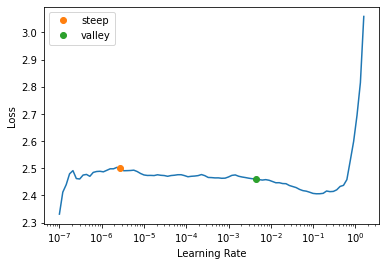

In [21]:
with safely_train_with_gpu():
    print(text_learn.lr_find(suggest_funcs=(steep, valley)))

In [29]:
lr = 3e-3

In [30]:
with safely_train_with_gpu():
    text_learn.freeze_to(-1)
    text_learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.266023,2.156515,0.262374,00:02


In [31]:
with safely_train_with_gpu():
    text_learn.freeze_to(-2)
    text_learn.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2))

epoch,train_loss,valid_loss,accuracy,time
0,2.177133,2.072932,0.283518,00:02


In [32]:
with safely_train_with_gpu():
    text_learn.freeze_to(-3)
    text_learn.fit_one_cycle(1, slice(lr/4/(2.6**4),lr/4))

epoch,train_loss,valid_loss,accuracy,time
0,2.126456,2.037622,0.258049,00:03


In [33]:
with safely_train_with_gpu():
    text_learn.unfreeze()
    text_learn.fit_one_cycle(5, slice(lr/5/(2.6**4),lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,2.122236,2.010107,0.308506,00:03
1,2.089070,2.004427,0.308986,00:03
2,2.051673,1.996533,0.308506,00:03
3,2.041950,1.975711,0.308506,00:03
4,2.022108,2.016383,0.308986,00:03
